In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/andrewchavarria/Desktop/JupyterLab/HeartFailure/heart.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.shape

(918, 12)

# Data Visualization

array([[<AxesSubplot: title={'center': 'Age'}>]], dtype=object)

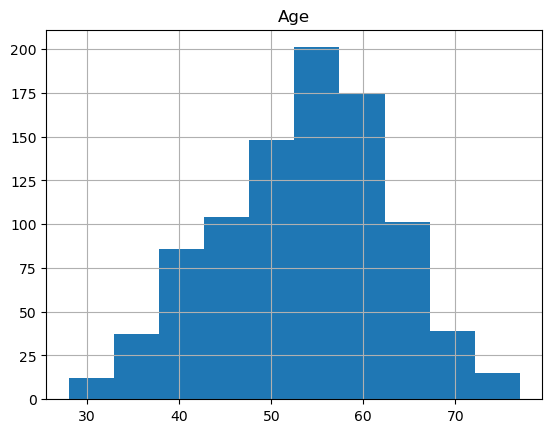

In [5]:
df.hist('Age')

In [6]:
# Check to see that no entries in the dataset are NA
print("Missing values in the dataset?: "+ str(df.isnull().values.any()))

Missing values in the dataset?: False


Text(0, 0.5, 'Max Heart Rate')

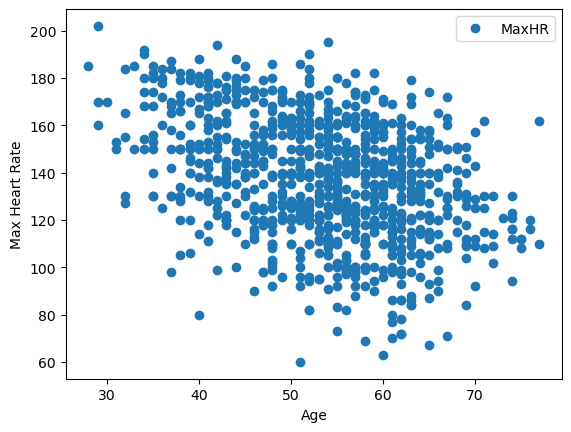

In [7]:
ax = df.plot(x='Age', y='MaxHR', style='o')
ax.set_xlabel("Age")
ax.set_ylabel("Max Heart Rate")

Text(0, 0.5, 'Cholesterol')

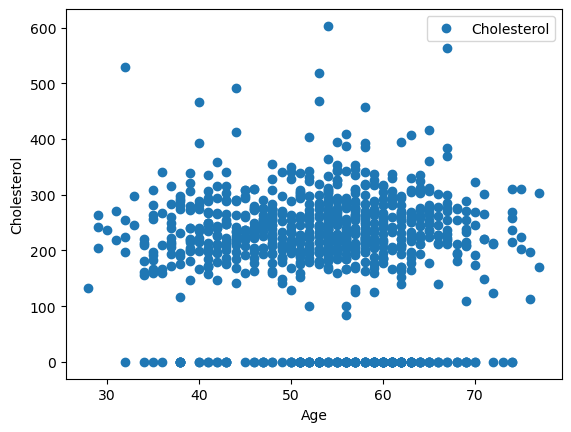

In [8]:
ax = df.plot(x='Age', y='Cholesterol', style='o')
ax.set_xlabel("Age")
ax.set_ylabel("Cholesterol")

[Text(0, 0, '410'), Text(0, 0, '508')]

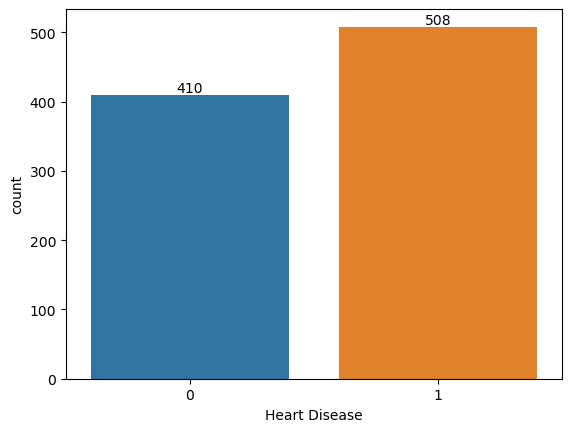

In [9]:
ax = sns.countplot(x=df["HeartDisease"])
ax.set_xlabel("Heart Disease")
plt.bar_label(ax.containers[0])

<AxesSubplot: xlabel='ST_Slope', ylabel='count'>

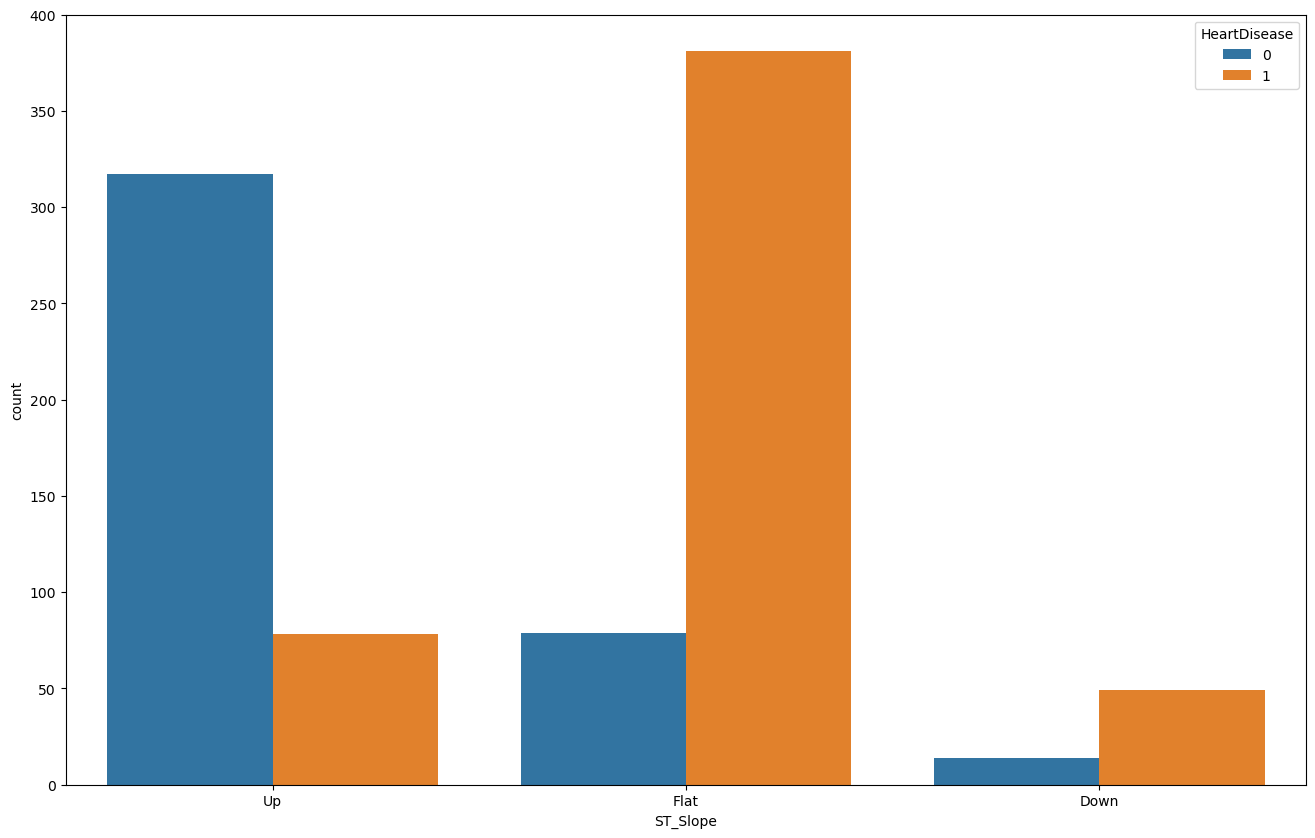

In [10]:
plt.figure(figsize=(16,10))
sns.countplot(x="ST_Slope",data=df,hue="HeartDisease")

<AxesSubplot: xlabel='ExerciseAngina', ylabel='count'>

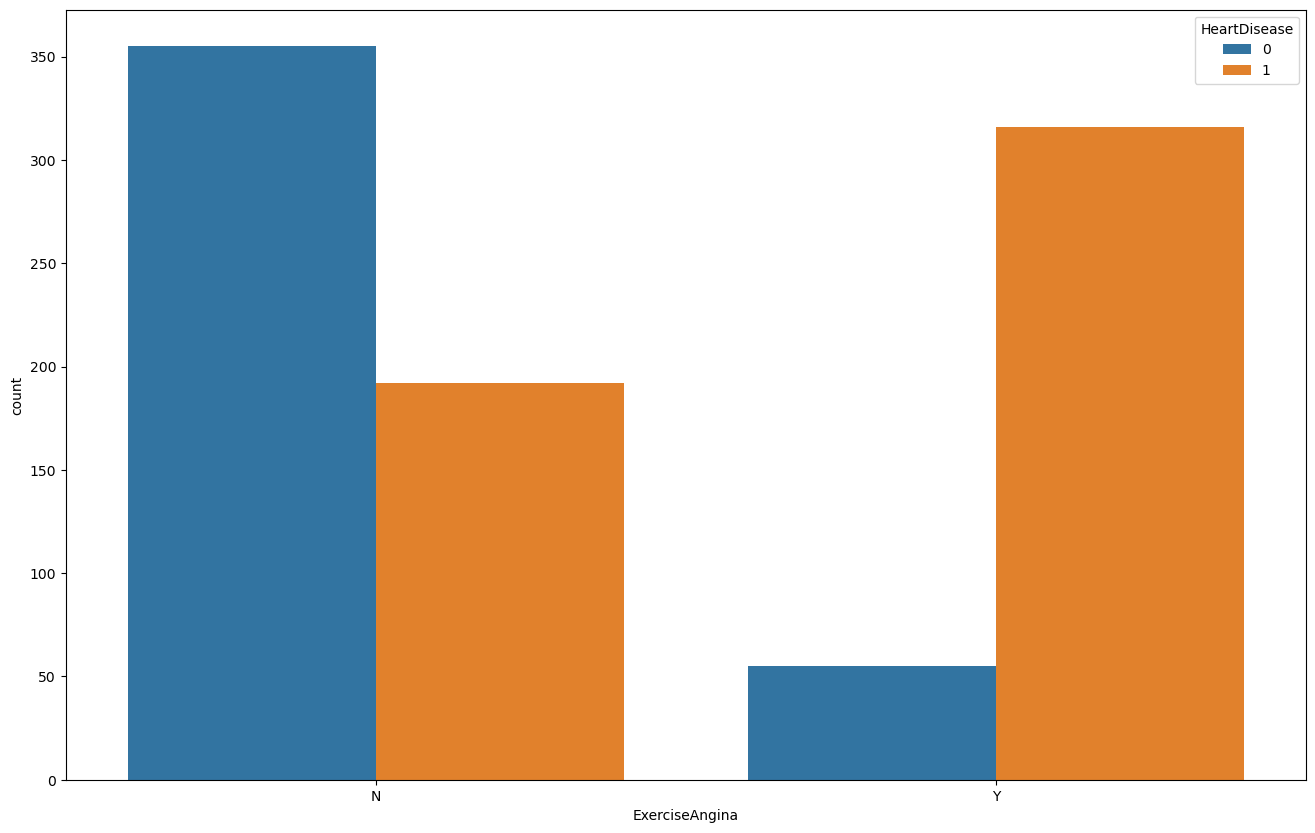

In [11]:
plt.figure(figsize=(16,10))
sns.countplot(x="ExerciseAngina",data=df,hue="HeartDisease")

<AxesSubplot: xlabel='ChestPainType', ylabel='count'>

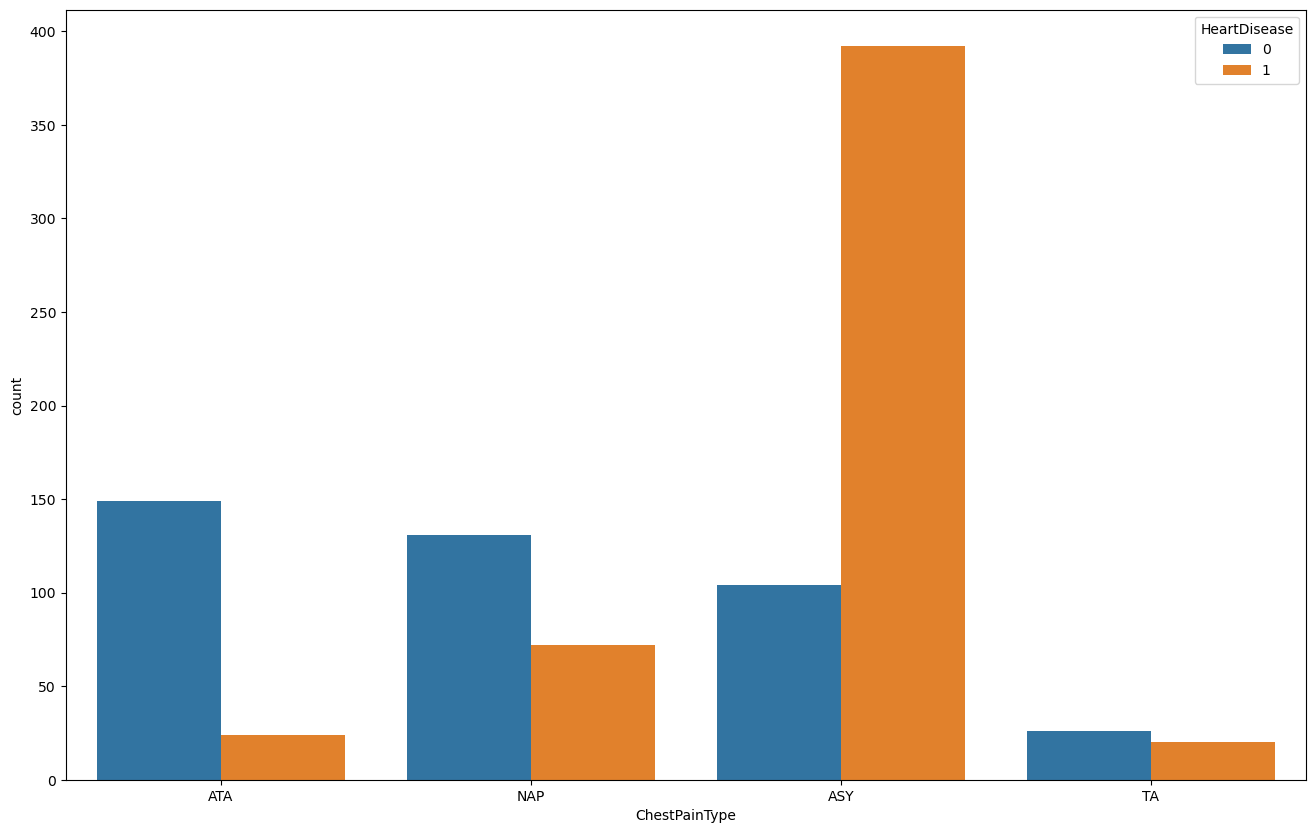

In [12]:
plt.figure(figsize=(16,10))
sns.countplot(x="ChestPainType",data=df,hue="HeartDisease")

[]

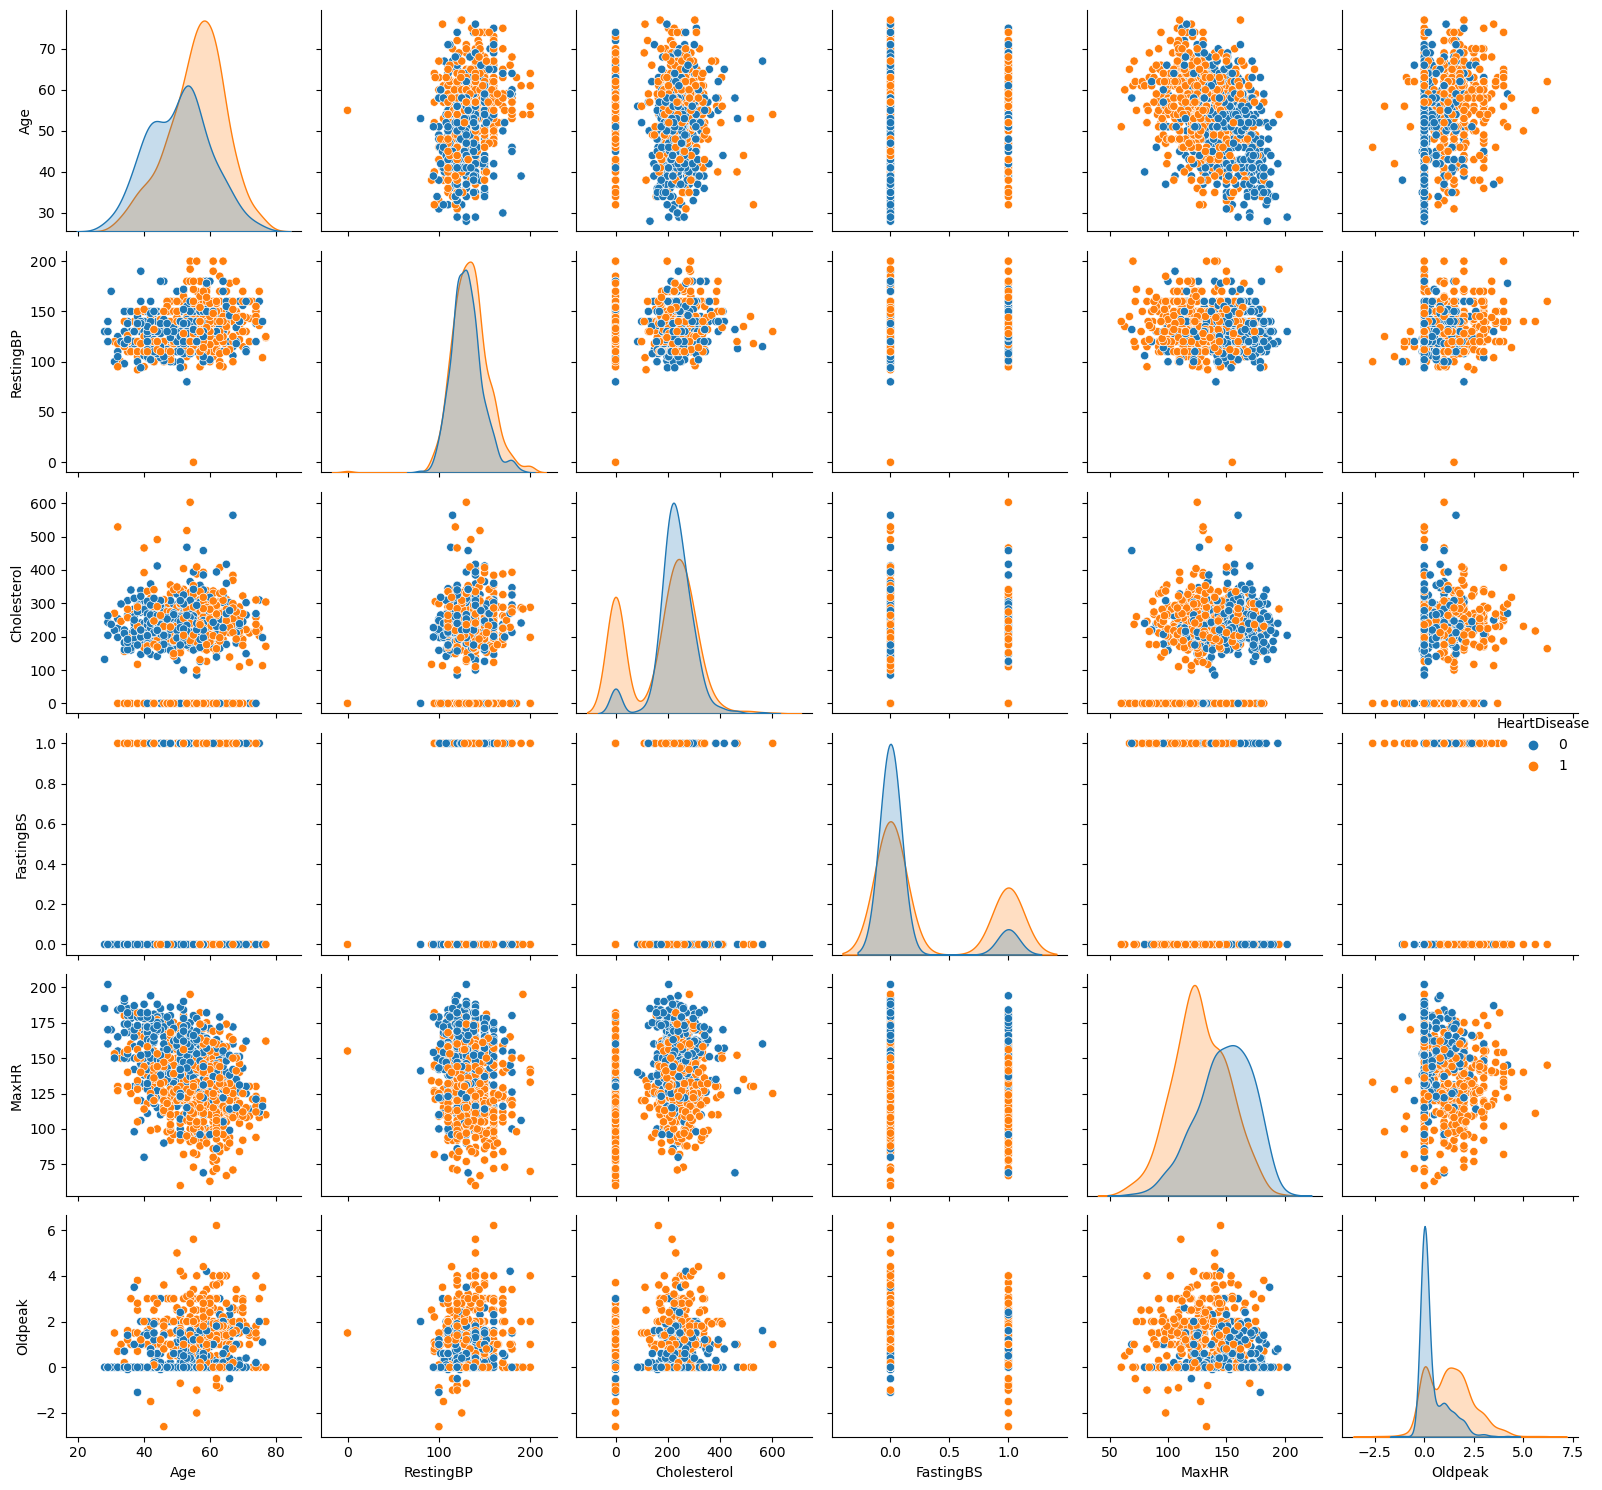

In [13]:
sns.pairplot(df,hue='HeartDisease')
plt.tight_layout()
plt.plot()

<AxesSubplot: >

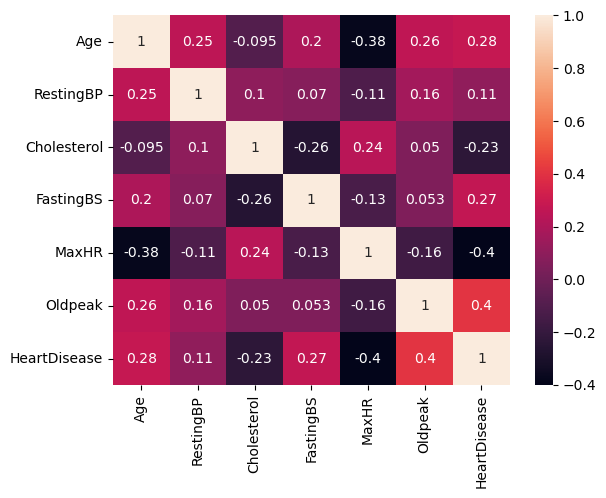

In [14]:
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(df.corr(), annot= True)

In [15]:
#One-hot encode the necessary variables

df = pd.get_dummies(df, columns=['ChestPainType'],drop_first=True)
df = pd.get_dummies(df, columns=['RestingECG'],drop_first=True)
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df = pd.get_dummies(df, columns=['ExerciseAngina'], drop_first=True)
df = pd.get_dummies(df, columns=['ST_Slope'], drop_first=True)

In [16]:
X = df.drop("HeartDisease", axis=1)
y = df['HeartDisease']

In [17]:
#Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calulcate std dev and mean, and then fit to our test data.
X_norm = scaler.fit_transform(X)

## Model Selection 

First, we will use a classic Decsion Tree model to predict Heart Disease. After this, we will use an XGBoost tree implementation with our dataset and compare the performance.

## Decision Tree Implementation

In [18]:
from sklearn import tree
from sklearn.model_selection import train_test_split

In [19]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train_scaled, x_, y_train, y_ = train_test_split(X_norm, y, test_size=0.30, random_state=1, shuffle=True)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv_scaled, x_test_scaled, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1, shuffle=True)

# Delete temporary variables
del x_, y_

In [20]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_scaled, y_train)

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred = clf.predict(x_train_scaled)
print("Classification report for the training set: ")
print(classification_report(y_train, y_pred))

y_pred = clf.predict(x_cv_scaled)
print("Classification report for the dev set: ")
print(classification_report(y_cv,y_pred))

print(f1_score(y_cv, y_pred, average=None))

Classification report for the training set: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00       341

    accuracy                           1.00       642
   macro avg       1.00      1.00      1.00       642
weighted avg       1.00      1.00      1.00       642

Classification report for the dev set: 
              precision    recall  f1-score   support

           0       0.59      0.75      0.66        55
           1       0.80      0.66      0.72        83

    accuracy                           0.70       138
   macro avg       0.70      0.70      0.69       138
weighted avg       0.72      0.70      0.70       138

[0.66129032 0.72368421]


Clearly there is overfitting because the training set is performing perfectly, yet the cross validation set performance is not up to par.

Let's fine tune the hyperparameters to construct a better tree.

## Parameter fine-tuning for Decision Trees

### Max Depth

In [22]:
print("Current Max Depth: "+ str(clf.tree_.max_depth))
curr_max = clf.tree_.max_depth

Current Max Depth: 11


In [23]:
training_f1_scores = []
cv_f1_scores = []

best_depth = 0
F_1_score = 0

for i in range(1, curr_max):
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(x_train_scaled, y_train)
    y_pred_cv = clf.predict(x_cv_scaled)
    y_pred_train = clf.predict(x_train_scaled)
            
    
    curr_f1_cv = np.mean(f1_score(y_cv, y_pred_cv, average=None))
    curr_f1_train = np.mean(f1_score(y_train, y_pred_train, average=None))
    
    training_f1_scores.append(curr_f1_train)
    cv_f1_scores.append(curr_f1_cv)
    
    
    if(F_1_score < curr_f1_cv):
        F_1_score = curr_f1_cv
        best_depth = i
        
print("Best depth: "+str(best_depth));
print("F1 Score: "+str(F_1_score));

Best depth: 1
F1 Score: 0.8457066189624328


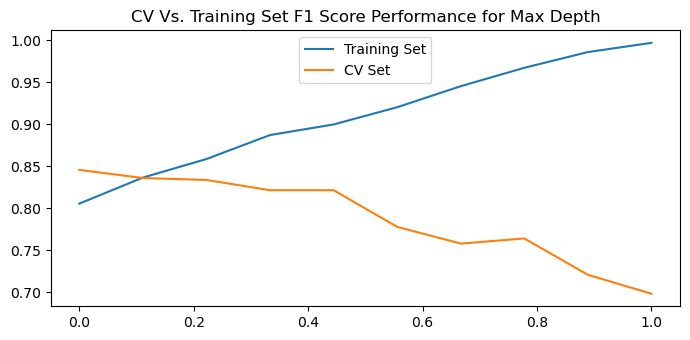

In [24]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True


x1 = np.linspace(0, 1, 10)
x2 = np.linspace(0, 1, 10)

plt.plot(x1, training_f1_scores, label="Training Set")
plt.plot(x2, cv_f1_scores, label="CV Set")

leg = plt.legend(loc='upper center')

plt.title("CV Vs. Training Set F1 Score Performance for Max Depth")
plt.show()

[Text(0.5, 0.75, 'X[14] <= 0.141\ngini = 0.498\nsamples = 642\nvalue = [301, 341]'),
 Text(0.25, 0.25, 'gini = 0.311\nsamples = 353\nvalue = [68, 285]'),
 Text(0.75, 0.25, 'gini = 0.312\nsamples = 289\nvalue = [233, 56]')]

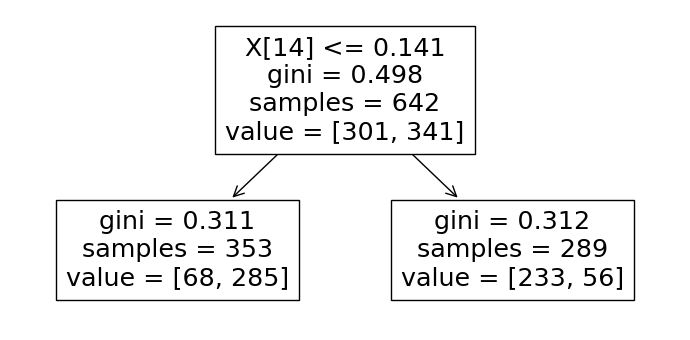

In [25]:
clf = tree.DecisionTreeClassifier(max_depth = 1)
clf = clf.fit(x_train_scaled, y_train)
y_pred = clf.predict(x_cv_scaled)

tree.plot_tree(clf)

The 14th feature, ST_Slope_Up seems to be the biggest predictor of whether or not the patient has Heart Disease. The decision tree peforms best on this one split for the dev set.

### Max leaf nodes

In [26]:
best_max_leaf_nodes = 0

F_1_score = 0

for i in range(2, 30):
    clf = tree.DecisionTreeClassifier(max_depth = best_depth, max_leaf_nodes = i)
    clf = clf.fit(x_train_scaled, y_train)
    y_pred = clf.predict(x_cv_scaled)
            
    
    curr_f1 = np.mean(f1_score(y_cv, y_pred, average=None))
    if(F_1_score < curr_f1):
        F_1_score = curr_f1
        best_max_leaf_nodes = i
        
print("Best max_leaf_nodes: "+str(best_max_leaf_nodes));
print("F1 Score: "+str(F_1_score));

Best max_leaf_nodes: 2
F1 Score: 0.8457066189624328


## Test Set Evaluation for Decision Tree

In [27]:
clf = tree.DecisionTreeClassifier(max_depth = best_depth, max_leaf_nodes = best_max_leaf_nodes)
clf = clf.fit(x_train_scaled, y_train)

print("CV set performance\n")
y_pred_cv = clf.predict(x_cv_scaled)
print(classification_report(y_cv,y_pred_cv))

y_pred_test = clf.predict(x_test_scaled)
print("Test set performance\n")
print(classification_report(y_test,y_pred_test))

CV set performance

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        55
           1       0.85      0.92      0.88        83

    accuracy                           0.86       138
   macro avg       0.86      0.84      0.85       138
weighted avg       0.86      0.86      0.85       138

Test set performance

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        54
           1       0.85      0.82      0.84        84

    accuracy                           0.80       138
   macro avg       0.79      0.80      0.80       138
weighted avg       0.81      0.80      0.81       138



# XGBoost Implementation

In [28]:
from xgboost import XGBClassifier

In [29]:
xgb = XGBClassifier()

In [30]:
xgb.fit(x_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [31]:
y_pred_train = xgb.predict(x_train_scaled)
print("Classification report for the training set: ")
print(classification_report(y_train, y_pred_train))

y_pred_cv = xgb.predict(x_cv_scaled)
print("Classification report for the dev set: ")
print(classification_report(y_cv,y_pred_cv))

Classification report for the training set: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00       341

    accuracy                           1.00       642
   macro avg       1.00      1.00      1.00       642
weighted avg       1.00      1.00      1.00       642

Classification report for the dev set: 
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        55
           1       0.92      0.84      0.88        83

    accuracy                           0.86       138
   macro avg       0.86      0.87      0.86       138
weighted avg       0.87      0.86      0.86       138



## Parameter fine-tuning for XGBoost

### Max_depth

In [32]:
training_f1_scores = []
cv_f1_scores = []

best_depth = 0
F_1_score = 0

for i in range(1, 10):
    xgb = XGBClassifier(max_depth = i)
    xgb = xgb.fit(x_train_scaled, y_train)    
    y_pred_cv = xgb.predict(x_cv_scaled)
    y_pred_train = xgb.predict(x_train_scaled)
            
    curr_f1_cv = np.mean(f1_score(y_cv, y_pred_cv, average=None))
    curr_f1_train = np.mean(f1_score(y_train, y_pred_train, average=None))
    
        
    training_f1_scores.append(curr_f1_train)
    cv_f1_scores.append(curr_f1_cv)

    if(F_1_score < curr_f1_cv):
        F_1_score = curr_f1_cv
        best_depth = i
        
print("Best depth: "+str(best_depth));
print("F1 Score: "+str(F_1_score));

Best depth: 1
F1 Score: 0.8738913078535719


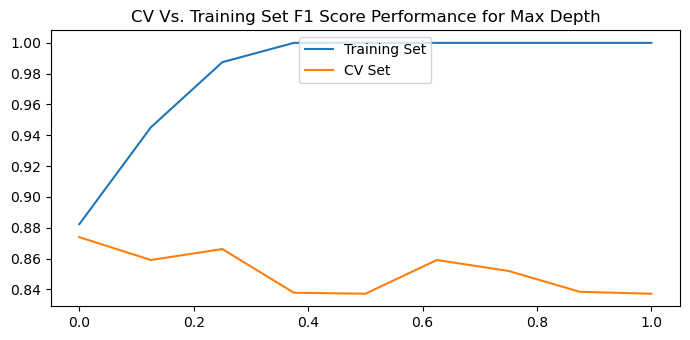

In [33]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True


x1 = np.linspace(0, 1, 9)
x2 = np.linspace(0, 1, 9)

plt.plot(x1, training_f1_scores, label="Training Set")
plt.plot(x2, cv_f1_scores, label="CV Set")

leg = plt.legend(loc='upper center')

plt.title("CV Vs. Training Set F1 Score Performance for Max Depth")
plt.show()

### min_child_weight

In [34]:
best_min_child_weight = 1

F_1_score = 0

for i in range(1, 10):
    xgb = XGBClassifier(max_depth = best_depth, min_child_weight = i)
    xgb = xgb.fit(x_train_scaled, y_train)
    y_pred = xgb.predict(x_cv_scaled)
            
    
    curr_f1 = np.mean(f1_score(y_cv, y_pred, average=None))
    if(F_1_score < curr_f1):
        F_1_score = curr_f1
        best_min_child_weight = i
        
print("Best min_child_weight: "+str(best_min_child_weight));
print("F1 Score: "+str(F_1_score));

Best min_child_weight: 2
F1 Score: 0.8810344827586207


### Gamma

In [35]:
best_gamma= 0

F_1_score = 0

for i in range(0, 10):
    xgb = XGBClassifier(max_depth = best_depth, min_child_weight = best_min_child_weight, gamma = i)
    xgb = xgb.fit(x_train_scaled, y_train)
    y_pred = xgb.predict(x_cv_scaled)
            
    
    curr_f1 = np.mean(f1_score(y_cv, y_pred, average=None))
    if(F_1_score < curr_f1):
        F_1_score = curr_f1
        best_gamma = i
        
print("Best gamma: "+str(best_gamma));
print("F1 Score: "+str(F_1_score));

Best gamma: 2
F1 Score: 0.8887276245766811


Chosen XGBoost hyperparameters after fine-tuning: <br><br>
    max_depth = 1<br>
    min_child_weight = 2<br>
    gamma = 2

## Test Set Evaluation for XGBoost

In [36]:
xgb = XGBClassifier(max_depth = best_depth, min_child_weight = best_min_child_weight, gamma = best_gamma)
xgb = xgb.fit(x_train_scaled, y_train)

print("CV set performance\n")
y_pred_cv = xgb.predict(x_cv_scaled)
print(classification_report(y_cv,y_pred_cv))


print("Test set performance\n")
y_pred_test = xgb.predict(x_test_scaled)
print(classification_report(y_test,y_pred_test))


CV set performance

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        55
           1       0.95      0.87      0.91        83

    accuracy                           0.89       138
   macro avg       0.88      0.90      0.89       138
weighted avg       0.90      0.89      0.89       138

Test set performance

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        54
           1       0.91      0.89      0.90        84

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.89      0.88      0.88       138



## Conclusion

The XGBoost implementation offers better performance. Even after fine-tuning the hyperparameters for the Decision Tree, the XGBoost algorithm with no fine-tuning still performs better than the former.